In [2]:
#this notebook simply runs a neural synth but uses masks generated by the CompositionGAN
#the improvement is that neural synth no longer clutters the whole frame and its output 
#is organized in a meaningful composition
#Ive taken this a step further and saved the outputs as black and white images. One way to 
#improve this work would be to find a way to make a neural synth be selective about it's 
#color pallette. 

In [9]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import scipy.misc
import tensorflow as tf
from lapnorm import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [10]:
def lapnorm_multi(t_obj, img0, mask, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=True):
    mask_sizes = get_mask_sizes(mask.shape[0:2], oct_n, oct_s)
    img0 = resize(img0, np.int32(mask_sizes[0])) 
    t_score = [tf.reduce_mean(t) for t in t_obj] # defining the optimization objective
    t_grad = [tf.gradients(t, t_input)[0] for t in t_score] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = mask_sizes[octave] #np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        oct_mask = resize(mask, np.int32(mask_sizes[octave]))
        for i in range(iter_n):
            g_tiled = [lap_norm_func(calc_grad_tiled(img, t)) for t in t_grad]
            for g, gt in enumerate(g_tiled):
                img += gt * step * oct_mask[:,:,g].reshape((oct_mask.shape[0],oct_mask.shape[1],1))
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    if clear:
        clear_output()
    return img

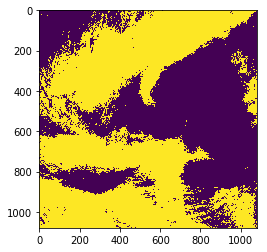

In [11]:
# bring in clusters and do some formatting
clusters = pd.read_csv('../data2/largecompositions.csv')

cArray = np.array(clusters)
cArray = np.delete(cArray, (0), axis=1)

plt.imshow(cArray[0].reshape(1080, 1080))

In [ ]:
# h, w = 100, 100

# img0 = np.random.uniform(size=(h, w, 3)) + 100.0

n = len(cArray)

# octave_n = 3
# octave_scale = 1.4
# objectives = [T('mixed3b_5x5_bottleneck_pre_relu')[:,:,:,9], 
#               T('mixed3b_5x5_bottleneck_pre_relu')[:,:,:,0]]
# images = []
# for item in cArray:
#     mask = np.zeros((h, w, 3))
#     mask[:,:,1] = item.reshape(h, w)
#     mask[:,:,1] = item.reshape(h, w)
#     img1 = lapnorm_multi(objectives, img0, mask, iter_n=20, step=1.0, oct_n=3, oct_s=1.4, lap_n=4)
#     images.append[img1]
    
# for img in images:
#     display_image(img)

h, w = 1080, 1080



octave_n = 3
octave_scale = 1.4
objectives = [T('mixed4a_5x5_pre_relu')[:,:,:,25], 
              T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,15]]

# repeat the generation loop 20 times. notice the feedback -- we make img and then use it the initial input 
for f in cArray:
    # start with random noise
    img = np.random.uniform(size=(h, w, 3)) + 100.0
    mask = np.zeros((h, w, 3))
    mask[:,:,0] = f.reshape(h, w)
    mask[:,:,1] = f.reshape(h, w)
    img = lapnorm_multi(objectives, img, mask, iter_n=20, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=False)
    display_image(img)    # let's see it
    img = resize(img[10:-10,10:-10,:], (h, w))  # before looping back, crop the border by 10 pixels, resize, repeat    